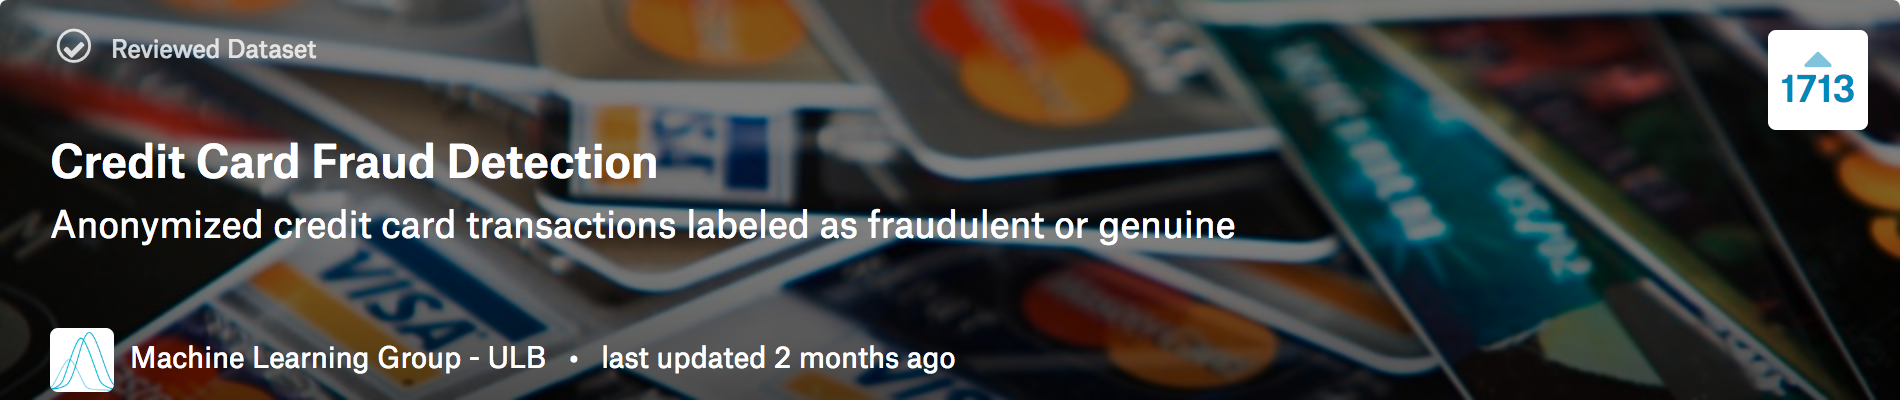

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import h5py

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [ ]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
X_train_set, X_test_set = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_set = X_train_set[X_train_set.Class == 0]
X_train_set = X_train_set.drop(['Class'], axis=1)
y_test_set = X_test_set['Class']
X_test_set = X_test_set.drop(['Class'], axis=1)

In [ ]:
print("total training data: "+str(X_train_set.shape[0]))

In [ ]:
print("total test data: "+str(X_test_set.shape[0]))

# Initialize variables and execution roles

In [ ]:
from sagemaker import get_execution_role

#Bucket location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://dnn-dataset/customcode/dnn_tensorflow_estimator'

#Bucket location where results of model training are saved.
model_artifacts_location = 's3://dnn-dataset/artifacts'

#IAM execution role that gives SageMaker access to resources in your AWS account.
role = get_execution_role()

# Construct Deep Neural Network Classifier

In [ ]:
!cat "dnn_classifier.py"

# Using a tf.estimator in SageMaker

In [ ]:
def estimator(model_path, hyperparameters):
    feature_columns = [tf.feature_column.numeric_column(INPUT_TENSOR_NAME, shape=[29])]
    return tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                      hidden_units=[10, 20, 10],
                                      n_classes=2,
                                      model_dir=model_path)

The code above first defines the model's feature columns, which specify the data type for the features in the data set. All the feature data is continuous, so tf.feature_column.numeric_column is the appropriate function to use to construct the feature columns. There are 29 features in the data set, so accordingly shape must be set to [29] to hold all the data.

Then, the code creates a DNNClassifier model using the following arguments:

feature_columns=feature_columns. The set of feature columns defined above.
hidden_units=[10, 20, 10]. Three hidden layers, containing 10, 20, and 10 neurons, respectively.
n_classes=2. Two target classes, representing the fraud type or normal type transaction.
model_dir=model_path. The directory in which TensorFlow will save checkpoint data during model training.

# Describe the training input pipeline

In [ ]:
def train_input_fn(training_dir, hyperparameters):
    training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
        filename=os.path.join(training_dir, 'train_data.csv'),
        target_dtype=np.int,
        features_dtype=np.float32)

    return tf.estimator.inputs.numpy_input_fn(
        x={INPUT_TENSOR_NAME: np.array(training_set.data)},
        y=np.array(training_set.target),
        num_epochs=None,
        shuffle=True)()

# Describe the serving input pipeline:

In [ ]:
def serving_input_fn(hyperparameters):
    feature_spec = {INPUT_TENSOR_NAME: tf.FixedLenFeature(dtype=tf.float32, shape=[29])}
    return tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)()

# Train model

Pass the path to the dnn_classifier.py file, which contains the functions for defining your estimator, to the sagemaker.TensorFlow init method.

Pass the S3 location that we uploaded our data to previously to the fit() method.

In [ ]:
from sagemaker.tensorflow import TensorFlow

iris_estimator = TensorFlow(entry_point='dnn_classifier.py',
                            role=role,
                            output_path=model_artifacts_location,
                            code_location=custom_code_upload_location,
                            train_instance_count=1,
                            train_instance_type='ml.c4.xlarge',
                            training_steps=1000,
                            evaluation_steps=100)

In [ ]:
%%time
import boto3

# use the region-specific sample data bucket
region = boto3.Session().region_name
train_data_location = 's3://dnn-dataset'.format(region)

iris_estimator.fit(train_data_location)

# Deploy trained model

In [ ]:
%%time
iris_predictor = iris_estimator.deploy(initial_instance_count=1,
                                       instance_type='ml.m4.xlarge')

# Invoke the Endpoint to get inferences

Invoking prediction:

In [ ]:
iris_predictor.predict([-15.819178720771802,8.7759971528627,-22.8046864614815,11.864868080360699,-9.09236053189517,-2.38689320657655,-16.5603681078199,0.9483485947860579,-6.31065843275059,-13.0888909176936,9.81570317447819,-14.0560611837648,0.777191846436601,-13.7610179615936,-0.353635939812489,-7.9574472262599505,-11.9629542349435,-4.7805077876172,0.652498045264831,0.992278949261366,-2.35063374523783,1.03636187430048,1.13605073696052,-1.0434137405139001,-0.10892334328197999,0.657436778462222,2.1364244708551396,-1.41194537483904,-0.3492313067728856]) #expected label to be 1

# Delete Endpoint

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(iris_predictor.endpoint)